# Probabilistic CFG parsing

This notebook demonstrates the process behind parsing with a probabilistic (weighted) context free grammar. The algorithm here is based on the CYK algorithm for PCFG parsing, as described in Figure 14.3 J&M2 and presented in the lecture. Note that NLTK implements a few probabilistic parsing methods internally, which are a little different to the algorithm presented in the lecture but are an excellent resource (see pointer at the bottom).

In [2]:
import nltk
import nltk.grammar
from collections import defaultdict
from IPython.core.display import display, HTML

As a warm-up let's start by creating a standard (unweighted) CFG grammar and parse a simple sentence.

In [3]:
groucho_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
Det -> 'a' | 'an' | 'my' | 'the' 
N -> 'elephant' | 'pajamas' | 'shot'
V -> 'shot'
P -> 'in'
""")

Our sentence is chosen to be ambiguous, note that there are two ways in which the following can be parsed.

In [4]:
sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']
parser = nltk.ChartParser(groucho_grammar)
trees = list(parser.parse(sent))
print(len(trees))
print(trees[0])
print(trees[1])

2
(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas)))))
(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas))))))


These trees can be visualised in a more comprehensible way

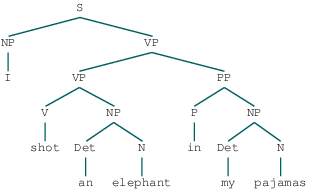

In [5]:
trees[0]

If you get a lot of warnings in the above, and no pretty tree, then that means you're missing the *ghostview* library. It comes standard with linux and mac, I think, but you may need to install it yourself on windows. You can obtain a copy of the GPL binary [from the ghostview website](http://www.ghostscript.com/download/gsdnld.html). If you're on a locked-down machine, and can't install, you may want to view the tree as follows:

In [8]:
# ASCII art
trees[0].pretty_print()

     S                                       
  ___|______________                          
 |                  VP                       
 |         _________|__________               
 |        VP                   PP            
 |    ____|___              ___|___           
 |   |        NP           |       NP        
 |   |     ___|_____       |    ___|_____     
 NP  V   Det        N      P  Det        N   
 |   |    |         |      |   |         |    
 I  shot  an     elephant  in  my     pajamas



In [6]:
# launches a popup window
trees[0].draw()

And here's the other tree

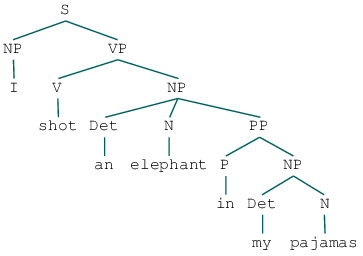

In [10]:
trees[1]

Now we will move to a PCFG, where each rule has a weight denoted by a bracket [number] after each production. Here's a fairly simple (different) grammar, which we will use to develop and demonstrate the CYK parsing algorithm.

In [7]:
toy_pcfg2 = nltk.grammar.PCFG.fromstring("""
    S    -> NP VP         [1.0]
    VP   -> V NP          [.59]
    VP   -> V             [.40]
    VP   -> VP PP         [.01]
    NP   -> Det N         [.41]
    NP   -> Name          [.28]
    NP   -> NP PP         [.31]
    PP   -> P NP          [1.0]
    V    -> 'saw'         [.21]
    V    -> 'ate'         [.51]
    V    -> 'ran'         [.28]
    N    -> 'boy'         [.11]
    N    -> 'cookie'      [.12]
    N    -> 'table'       [.13]
    N    -> 'telescope'   [.14]
    N    -> 'hill'        [.5]
    Name -> 'Jack'        [.52]
    Name -> 'Bob'         [.48]
    P    -> 'with'        [.61]
    P    -> 'under'       [.39]
    Det  -> 'the'         [.41]
    Det  -> 'a'           [.31]
    Det  -> 'my'          [.28]
    """)

First we need to check that the grammar is in Chomsky normal form (CNF), as this is a condition for using the CYK parsing algorithm. Recall that CNF means that all rules are either X -> A B or X -> 'word', where capitals denote non-terminal symbols.

In [8]:
print(toy_pcfg2.is_chomsky_normal_form())
print(toy_pcfg2.is_flexible_chomsky_normal_form())

False
True


Nope. This is because of the unary productions X -> Y. Note that these can cause problems, especially when there is a loop (NP -> PP -> NP ...). This means the grammar can produce infinitely deep trees, and generally makes the algorithm more complex, as we would have to reduce the grammar to CNF by solving the total probability over any length chain. Note that as the probability of each production is bounded, $0 \le p \le 1$, long chains tend to be increasingly improbable.  However note that our grammar has no unary cycles, so we can ignore this problem. *Do you have any ideas on how this might be handled properly, in general?*

We can interact with the grammar in several ways. Have a little play below, e.g., to lookup a production and query its attributes.

In [15]:
p = toy_pcfg2.productions(rhs='saw')[0]
print(p.prob())
print(p.lhs())
q = toy_pcfg2.productions(rhs=p.lhs())
print(q)

0.21
V
[VP -> V NP [0.59], VP -> V [0.4]]


Now for the CYK parsing algorithm. This operates by incrementally constructing a *chart (table)* using dynamic programming. The chart stores the partial results thus far, which encodes the best scoring tree structure for substrings of the input sentence. These partial results are extended incrementally to find the best scoring structure for the whole sentence.

Recall that a sentence is indexed by the spaces between words, e.g.,

        0 this 1 is 2 an 3 example 4
        
such that words or strings of words can be represented as a pair of [start, end] indices. E.g., [2,3] = an; [1,4] = is an example. Each element in the chart is indexed as:

        table[i, j][non-terminal]
        
which stores a probability for parsing the string [i, j]. The CYK algorithm builds these from smaller units by searching for all i < k < j and all productions such that previous analyses that cover [i,k] and [k,j] might be combined using a binary production to cover [i,j]. For this to be valid, the symbols for the two spans must match the RHS of a production in the grammar, and the resulting non-terminal is the LHS of the production. 

You'll need to read J&M2 and the lecture slides for more details, or tinker with the code below to understand the process. (E.g., by adding a display call into the j loop.) 

In [43]:
def parse_CYK(words, grammar):
    table = defaultdict(dict)    
    back = defaultdict(dict)
    
    # righter-most index j
    for j in range(1, len(words)+1):
        # insert token preterminal rewrites, POS -> 'word'
        token = words[j-1]
        for prod in grammar.productions(rhs=token):
            if len(prod.rhs()) == 1:
                table[j-1,j][prod.lhs()] = prod.prob()

        # deal with pesky unary productions 
        changes = True
        cell = table[j-1,j]
        while changes:
            # repeat this loop until no rule changes; will infinitely
            # loop for grammars with a unary cycle
            changes = False
            for non_term in list(cell.keys()):
                prob = cell[non_term]
                for prod in grammar.productions(rhs=non_term):
                    if len(prod.rhs()) == 1:
                        unary_prob = prod.prob() * prob
                        if unary_prob > cell.get(prod.lhs(), 0):
                            cell[prod.lhs()] = unary_prob
                            back[j-1,j][prod.lhs()] = (None, prod)
                            changes = True
        
        # now look for larger productions that span [i, j]
        # allowing i to move leftward over the input
        for i in range(j-2, -1, -1):
            cell = table[i,j]
            # k is the split point, i < k < j
            for k in range(i+1, j):
                # find chart cells based on the split point
                left_cell = table[i,k]
                right_cell = table[k,j]
                # find binary productions which handle a valid symbol A from left cell, X -> A B
                for left_nt, left_prob in left_cell.items():
                    for prod in grammar.productions(rhs=left_nt):
                        if len(prod.rhs()) == 2:
                            # check if the left and right cells have a valid parse
                            right_prob = right_cell.get(prod.rhs()[1])
                            if left_prob != None and right_prob != None:
                                # score the partial parse
                                prob = prod.prob() * left_prob * right_prob
                                if prob > cell.get(prod.lhs(), 0.0):
                                    # if it exceeds the current best analysis, update the cell
                                    cell[prod.lhs()] = prob
                                    # and store a record of how we got here
                                    back[i,j][prod.lhs()] = (k, prod)
    
    # display the table and back pointers
    display_CYK_chart(words, table, back)

    # have to build the tree from the back pointers
    return build_tree(words, back, grammar.start(), i=0, j=len(words))

We now need to write the remaining functions. First creating the tree from the back-pointers, which operates recursively starting at the word sentence headed by the start symbol 'S' (i.e., cell [0, length, S]). Then it follows the back pointers to find where the span was split and what the child symbols were.  

In [44]:
def build_tree(words, back, symbol, i, j):
    backpointer = back[i, j].get(symbol)
    if backpointer == None:
        # X -> 'word' production
        assert j == i+1
        return nltk.tree.Tree(symbol, [words[i]])
    else:
        k, prod = back[i, j][symbol]
        if k != None:
            # X -> A B binary production
            left_subtree = build_tree(words, back, prod.rhs()[0], i=i, j=k)
            right_subtree = build_tree(words, back, prod.rhs()[1], i=k, j=j)
            return nltk.tree.Tree(symbol, [left_subtree, right_subtree])
        else:
            # X -> A unary production
            subtree = build_tree(words, back, prod.rhs()[0], i=i, j=j)
            return nltk.tree.Tree(symbol, [subtree])

And some pretty printing code to view the chart.

In [45]:
def display_CYK_chart(words, table, back):
    length = len(words)
    html = ''
    html += '<tr>'
    for i in range(length):
        html += '<td><i>%s<i></td>' % words[i]
    html += '</tr>'
    for i in range(length):
        html += '<tr>'
        for j in range(1, length+1):
            if j <= i:
                html += '<td>'
            else:
                html += "<td bgcolor='lightcyan'>"
                html += '[%d,%d]' % (i,j) 
                for symbol, prob in table.get((i,j), {}).items():
                    html += '<br><b>%s</b> [%.5f]' % (str(symbol), prob)
                    b = back[i,j].get(symbol)
                    if b != None:
                        html += '<br>&nbsp; (k=%s, %s)' % (b[0], str(b[1]))
            html += '</td>'
        html += '</tr>'
    display(HTML(html))

Finally we are ready to parse! Let's set it loose on a simple sentence.

Jack,saw,Bob,with,my,cookie
"[0,1]Name [0.52000]NP [0.14560] (k=None, NP -> Name [0.28])","[0,2]S [0.01223] (k=1, S -> NP VP [1.0])","[0,3]S [0.00242] (k=1, S -> NP VP [1.0])","[0,4]","[0,5]","[0,6]S [0.00001] (k=1, S -> NP VP [1.0])"
,"[1,2]VP [0.08400] (k=None, VP -> V [0.4])V [0.21000]","[1,3]VP [0.01665] (k=2, VP -> V NP [0.59])","[1,4]","[1,5]","[1,6]VP [0.00004] (k=2, VP -> V NP [0.59])"
,,"[2,3]Name [0.48000]NP [0.13440] (k=None, NP -> Name [0.28])","[2,4]","[2,5]","[2,6]NP [0.00035] (k=3, NP -> NP PP [0.31])"
,,,"[3,4]P [0.61000]","[3,5]","[3,6]PP [0.00840] (k=4, PP -> P NP [1.0])"
,,,,"[4,5]Det [0.28000]","[4,6]NP [0.01378] (k=5, NP -> Det N [0.41])"
,,,,,"[5,6]N [0.12000]"


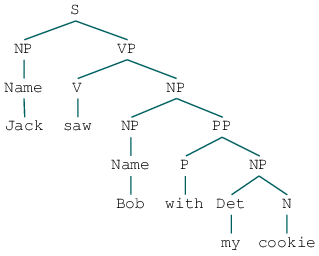

In [46]:
parse_CYK('Jack saw Bob with my cookie'.split(), toy_pcfg2)

Finally, feel free to investage NLTK's grammar and parsing algorithms. These live in `nltk.grammar`, `nltk.tree` and `nltk.parse`. Here's a good entry point:

In [47]:
import nltk.grammar
nltk.grammar.pcfg_demo()

A PCFG production: NP -> NP PP [0.25]
    pcfg_prod.lhs()  => NP
    pcfg_prod.rhs()  => (NP, PP)
    pcfg_prod.prob() => 0.25

A PCFG grammar: <Grammar with 23 productions>
    grammar.start()       => S
    grammar.productions() => [S -> NP VP [1.0],
                           VP -> V NP [0.59],
                           VP -> V [0.4],
                           VP -> VP PP [0.01],
                           NP -> Det N [0.41],
                           NP -> Name [0.28],
                           NP -> NP PP [0.31],
                           PP -> P NP [1.0],
                           V -> 'saw' [0.21],
                           V -> 'ate' [0.51],
                           V -> 'ran' [0.28],
                           N -> 'boy' [0.11],
                           N -> 'cookie' [0.12],
                           N -> 'table' [0.13],
                           N -> 'telescope' [0.14],
                           N -> 'hill' [0.5],
                           Name -> 'Jack' [0.52]

In [1]:
from nltk.parse.stanford import StanfordDependencyParser


In [2]:
dep_parser = StanfordDependencyParser(model_path='./englishPCFG.ser.gz')

LookupError: 

===========================================================================
  NLTK was unable to find stanford-parser\.jar! Set the CLASSPATH
  environment variable.

  For more information, on stanford-parser\.jar, see:
    <http://nlp.stanford.edu/software/lex-parser.shtml>
===========================================================================